In [1]:
import cv2
from IPython import display
from PIL import Image
import torch
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt

# Let's try to write a simple video loader

In [112]:
def video_loader(path, yield_each=1, width=100, height=None, show=False, jupyter_notebook=False):

    cap = cv2.VideoCapture(path)
    
    frame_number = 0

    while(cap.isOpened()):
        ret, frame = cap.read()
        if frame_number % yield_each == 0:
            try:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            except:
                break
            new_width = width
            new_height = int(frame.shape[0] / (frame.shape[1] / new_width))
            dim = (new_width, new_height)
            frame = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
            frame_number += 1
            yield torch.tensor(frame, dtype=torch.float32) / 255.
        else:
            frame_number += 1
            continue
        
        if height is not None:
            raise NotImplementedError
        
        if show:
            if jupyter_notebook:
                display.clear_output(wait=True)
                display.display(Image.fromarray(frame))
            else:
                frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                cv2.imshow('frame', frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

    if (not jupyter_notebook) and show:
        cv2.destroyAllWindows()
    cap.release()

# Cool, now we can view videos in jupyter...

In [ ]:
for each_frame in video_loader('../data/phase_I/video_0.mp4', 1, width=600, show=True, jupyter_notebook=True):
    pass

# ...and dedicated window

In [5]:
for each_frame in video_loader('../data/phase_I/video_0.mp4', 1, width=600, show=True, jupyter_notebook=False):
    pass

# Also we can use it as a data loader with frame skipping

In [21]:
# use every 30th frame

for each_frame in video_loader('../data/phase_I/video_0.mp4', 30, width=600, show=False, jupyter_notebook=False):
    pass

# Let's run some experiments with it to understand, if it is fast enough

In [113]:
%timeit for each_frame in video_loader('../data/phase_I/video_0.mp4', 1, width=600, show=False, jupyter_notebook=False): pass

5.29 s ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Not so fast!

---

# Let's switch to FFMPEG-based solutions

A quick research showed, that there is a tool `ffmpeg-python` for it

If `ffmpeg` library doesn't work, make sure you have `ffmpeg` installed and added to $PATH in your `tldetector` environment

In [3]:
import ffmpeg

In [ ]:
# Just a short demonstration

probe = ffmpeg.probe('../data/phase_I/video_0.mp4')
video_info = next(s for s in probe['streams'] if s['codec_type'] == 'video')
width = int(video_info['width'])
height = int(video_info['height'])
num_frames = int(video_info['nb_frames'])

out, err = (
    ffmpeg
    .input('../data/phase_I/video_0.mp4')
    .output('pipe:', format='rawvideo', pix_fmt='rgb24')
    .run(capture_stdout=True)
)
loaded_video = (
    np
    .frombuffer(out, np.uint8)
    .reshape([-1, height, width, 3])
)

@interact(frame=(0, num_frames-1))
def show_frame(frame=0):
    plt.imshow(loaded_video[frame,:,:,:])

In [50]:
def ffmpeg_video_loader(path, yield_each=1, width=100, height=None, show=False, jupyter_notebook=False):

    probe = ffmpeg.probe(path)
    video_info = next(s for s in probe['streams'] if s['codec_type'] == 'video')
    old_width = int(video_info['width'])
    old_height = int(video_info['height'])
    num_frames = int(video_info['nb_frames'])
    
    new_width = width
    new_height = int(old_height / (old_width / new_width))
    frame_size = new_width*new_height*3

    process = (
        ffmpeg
        .input('../data/phase_I/video_0.mp4')
        .filter('scale', new_width, new_height)
        .output('pipe:', format='rawvideo', pix_fmt='rgb24')
        .run_async(pipe_stdout=True)
    )
    
    for frame_number in range(num_frames):
        frame = (
            np
            .frombuffer(process.stdout.read(frame_size), np.uint8)
            .reshape(new_height, new_width, 3)
        )
        if frame_number % yield_each == 0:
            yield torch.tensor(frame, dtype=torch.float32) / 255.
        else:
            continue
        
        if height is not None:
            raise NotImplementedError
        
        if show:
            if jupyter_notebook:
                display.clear_output(wait=True)
                display.display(Image.fromarray(frame))
            else:
                frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                cv2.imshow('frame', frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

    if (not jupyter_notebook) and show:
        cv2.destroyAllWindows()

Usage is the same:

In [48]:
for each_frame in ffmpeg_video_loader('../data/phase_I/video_0.mp4', 1, width=600, show=True, jupyter_notebook=False):
    pass

In [114]:
%timeit for each_frame in ffmpeg_video_loader('../data/phase_I/video_0.mp4', 1, width=600, show=False, jupyter_notebook=False): pass

2.02 s ± 6.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Whoa, so much faster!

Let's now check that frames from these methods are the same:

In [78]:
ffmpeg_frames = torch.stack(list(ffmpeg_video_loader('../data/phase_I/video_0.mp4', 10, width=600, show=False, jupyter_notebook=False)))
opencv_frames = torch.stack(list(video_loader('../data/phase_I/video_0.mp4', 10, width=600, show=False, jupyter_notebook=False)))

In [83]:
ffmpeg_frames.shape

torch.Size([121, 337, 600, 3])

In [84]:
opencv_frames.shape

torch.Size([121, 337, 600, 3])

In [82]:
# but they are actually different!

torch.allclose(ffmpeg_frames, opencv_frames)

False

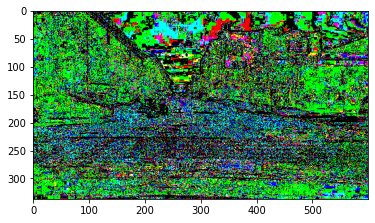

In [111]:
plt.imshow(np.array(ffmpeg_frames[-1] == opencv_frames[-1], dtype=np.float32))

### Well, they are different :) Seems FFMPEG uses other interpolation algorithm

However, making them exactly the same is a challenge for another experiment

Visually everything's ok